In [41]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

In [42]:
# load dark frames: dark-temp; each has 255 640x512 images
dark40 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-40.0C_2.496212_400.fits")
dark35 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-35.0C_2.496212_400.fits")
dark30 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-30.0C_2.4967610000000002_400.fits")
dark25 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-25.0C_2.4967610000000002_400.fits")
dark20 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-20.0C_2.4967610000000002_400.fits")
dark15 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-15.0C_2.4967610000000002_400.fits")
dark10 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-10.0C_2.4967610000000002_400.fits")
dark5 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-5.0C_2.4967610000000002_400.fits")
dark0 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/0.0C_2.4967610000000002_400.fits")
darks = [dark40, dark35, dark30, dark25, dark20, dark15, dark10, dark5, dark0]

In [43]:
# load and subtract master bias frame from dark frames
bias = np.mean(fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Bias/-40.0C_0.0028_5_dark_current_test.fits"), axis=0)
darks_subtracted = [dark - bias for dark in darks]
fits.PrimaryHDU(darks_subtracted[0]).writeto("darks_subtracted_.fits", overwrite=True)

In [44]:
# average dark frames over 255 reads:
dark_avgs = [np.mean(dark_sub, axis=0) for dark_sub in darks_subtracted]

# calculate mean pixel values at each temperature
pixel_avgs = [np.mean(dark_avg) for dark_avg in dark_avgs]

# calculate dark current = mean pixel value / exposure time
exposure_time = 2.5/1000 # all dark frames have the same exposure time (ms)
dark_current = [pixel_avg / exposure_time for pixel_avg in pixel_avgs] # list of dark currents in e-/s, sorted by temperature ascending
print(dark_current)


[76874.96292892158, 91018.70589192706, 97871.33725394454, 122585.3885426241, 151876.5066300935, 192023.03933536302, 248390.23118681062, 325971.05710497085, 455027.4174756816]


dark current increases at a rate of 8626.474368282144 e-/s per degree Celsius


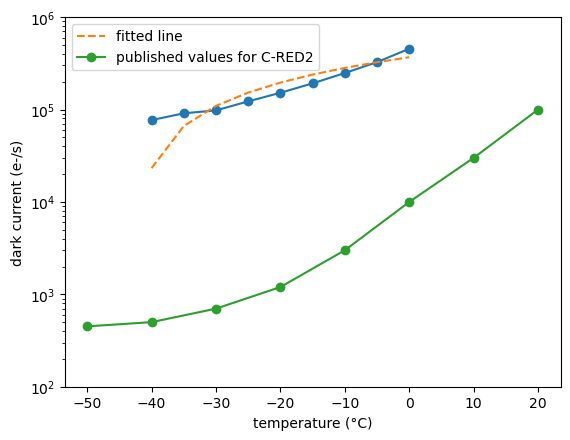

In [45]:
# plot temperature vs dark current
temp = [-40, -35, -30, -25, -20, -15, -10, -5, 0]
plt.plot(temp, dark_current, '-o')

# plot fitted line
coefs = np.polyfit(temp, dark_current, 1)
slope, intercept = coefs
dark_current_fit = [slope*t + intercept for t in temp]
plt.plot(temp, dark_current_fit, '--', label='fitted line')

# plot published dark current values
# these are for cred2 not cred2 er 
temp_pub = [-50, -40, -30, -20, -10, 0, 10, 20]
dark_current_pub = [450, 500, 700, 1200, 3000, 10000, 30000, 100000]
plt.plot(temp_pub, dark_current_pub, '-o', label='published values for C-RED2')

# other plot stuff
plt.ylabel('dark current (e-/s)')
plt.xlabel('temperature (°C)')
plt.yscale('log')
plt.ylim(10**2, 10**6)
plt.legend()

print('dark current increases at a rate of', slope, 'e-/s per degree Celsius')

In [46]:
# b/c previous measured dark current is so high, measure dark current again but w/ changing exposure time: dark current is supposed to increase with time
# -40C, 400 fps, tint=1, 2.5, 5, 10, 25, 50, 100, 200 ms
darkt1 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-40.0C_1.00269_5_retake.fits")
darkt2_5 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-40.0C_2.502526_5_retake.fits")
darkt5 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-40.0C_5.002251_5.fits")
darkt10 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-40.0C_10.001153_5_retake.fits")
darkt25 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-40.0C_25.000055_5.fits")
darkt50 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-40.0C_50.000493999999996_5.fits")
darkt100 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-40.0C_100.001373_5.fits")
darkt200 = fits.getdata(r"D:/HWP_Characterization/Data/Raw/CRED2_Characterization/Dark_Current/-40.0C_199.996761_5.fits")
darkts = [darkt1, darkt2_5, darkt5, darkt10, darkt25, darkt50, darkt100, darkt200]

In [47]:
# subtract bias
darkts_subtracted = [darkt - bias for darkt in darkts]

In [48]:
# average dark frames over 10 reads:
darkt_avgs = [np.mean(darkt, axis=0) for darkt in darkts_subtracted]

# calculate mean pixel values at each tint -> this is the avg dark signal or dark current
pixel_avgs_t = [np.mean(darkt_avg) for darkt_avg in darkt_avgs]
print(pixel_avgs_t) # negative values are due to defective frames in original image

[5.648224182128906, 15.164535522460938, 38.38354675292969, 67.65640808105469, 209.32021118164067, 422.95755035400396, 851.8948345947267, 1804.6097793579102]


dark current increases at a rate of 9008.261873144564 e-/s per 1 s


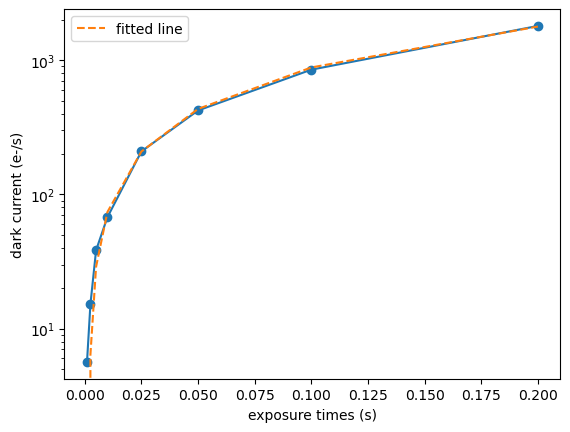

In [49]:
# plot tint vs dark current
exposure_times = [1/1000, 2.5/1000, 5/1000, 10/1000, 25/1000, 50/1000, 100/1000, 200/1000] # in s
plt.plot(exposure_times, pixel_avgs_t, '-o')

# plot fitted line
coefs = np.polyfit(exposure_times, pixel_avgs_t, 1)
slope, intercept = coefs
dark_current_fit = [slope*time + intercept for time in exposure_times]
plt.plot(exposure_times, dark_current_fit, '--', label='fitted line')

# other plot stuff
plt.ylabel('dark current (e-/s)')
plt.xlabel('exposure times (s)')
plt.yscale('log')
plt.legend()

print('dark current increases at a rate of', slope, 'e-/s per 1 s')